## SFR1 Manual Problem 2

This problem is based on the stream-aquifer interaction problem
described as Test 2 by Prudic et al 2004, which modifies another
problem originally described by Merritt et al 2000. The purpose
for including this problem is to demonstrate the use of MODFLOW 6
to simulate solute transport through a coupled system consisting
of an aquifer, streams, and lakes. The example requires accurate
simulation of transport within the streams and lakes and also
between the surface water features and the underlying aquifer.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwt-prudic2004t2"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = pl.Path(f"../data/{sim_name}")
data_path = data_path if data_path.is_dir() else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
hk = 250.0  # Horizontal hydraulic conductivity ($ft d^{-1}$)
vk = 125.0  # Vertical hydraulic conductivity ($ft d^{-1}$)
ss = 0.0  # Storage coefficient (unitless)
aquifer_thickness = 120.0  # Aquifer thickness ($ft$)
porosity = 0.30  # Porosity of mobile domain (unitless)
recharge = 4.79e-3  # Recharge rate ($ft d^{-1}$)
lakebed_leakance = 1.0  # Lakebed leakance ($ft^{-1}$)
streambed_k = 100.0  # Streambed hydraulic conductivity ($ft d^{-1}$)
streambed_thick = 1.0  # Streambed thickness ($ft$)
stream_width = 5.0  # Stream width ($ft$)
manning = 0.03  # Manning's roughness coefficient (unitless)
alpha_l = 20.0  # Longitudinal dispersivity ($ft$)
alpha_th = 2.0  # Transverse horizontal dispersivity ($ft$)
alpha_tv = 0.2  # Transverse vertical dispersivity ($ft$)
diffc = 0.0  # Diffusion coefficient ($ft^2 d^{-1}$)
cstrt = 0.0  # Initial concentration (micrograms per liter)
source_concentration = 500.0  # Source concentration (micrograms per liter)
nlay = 8  # Number of layers
nrow = 36  # Number of rows
ncol = 23  # Number of columns
delr = 405.665  # Column width ($ft$)
delc = 403.717  # Row width ($ft$)
delv = 15.0  # Layer thickness ($ft$)
top = 100.0  # Top of the model ($ft$)
total_time = 9131.0  # Total simulation time ($d$)

# Load Data Arrays
fname = "bot1.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:c510defe0eb1ba1fbfab5663ff63cd83",
)
bot0 = np.loadtxt(fpath)
botm = [bot0] + [bot0 - (15.0 * k) for k in range(1, nlay)]

fname = "idomain1.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:45d1ca08015e4a34125ccd95a83da0ee",
)
idomain0 = np.loadtxt(fpath, dtype=int)
idomain = nlay * [idomain0]

fname = "lakibd.dat"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:18c90af94c34825a206935b7ddace2f9",
)
lakibd = np.loadtxt(fpath, dtype=int)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def get_stream_data():
    fname = "stream.csv"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:1291c8dec5a415866c711ee14bf0b1f8",
    )
    dt = 5 * [int] + [float]
    streamdata = np.genfromtxt(fpath, names=True, delimiter=",", dtype=dt)
    connectiondata = [[ireach] for ireach in range(streamdata.shape[0])]
    isegold = -1
    distance_along_segment = []
    distance = 0
    for ireach, row in enumerate(streamdata):
        iseg = row["seg"] - 1
        if iseg == isegold:
            connectiondata[ireach].append(ireach - 1)
            connectiondata[ireach - 1].append(-ireach)
            distance += (
                streamdata["length"][ireach - 1] * 0.5
                + streamdata["length"][ireach] * 0.5
            )
        else:
            distance = 0.5 * streamdata["length"][ireach]
        isegold = iseg
        distance_along_segment.append(distance)
    # add a few additional connections
    connectiondata[17].append(-31)
    connectiondata[31].append(17)
    connectiondata[30].append(-31)
    connectiondata[31].append(30)
    packagedata = []
    segment_lengths = []
    for iseg in [1, 2, 3, 4]:
        idx = np.where(streamdata["seg"] == iseg)
        segment_length = streamdata["length"][idx].sum()
        segment_lengths.append(segment_length)
    emaxmin = [(49, 45), (44.5, 34), (41.5, 34.0), (34.0, 27.2)]
    segment_gradients = []
    for iseg, (emax, emin) in enumerate(emaxmin):
        segment_gradients.append((emax - emin) / segment_lengths[iseg])
    ustrf = 1.0
    ndv = 0
    for ireach, row in enumerate(streamdata):
        k, i, j = row["layer"] - 1, row["row"] - 1, row["col"] - 1
        length = row["length"]
        iseg = row["seg"] - 1
        rgrd = segment_gradients[iseg]
        emax, emin = emaxmin[iseg]
        rtp = distance_along_segment[ireach] / segment_lengths[iseg] * (emax - emin)
        rtp = emax - rtp
        boundname = f"SEG{iseg + 1}"
        rec = (
            ireach,
            (k, i, j),
            length,
            stream_width,
            rgrd,
            rtp,
            streambed_thick,
            streambed_k,
            manning,
            len(connectiondata[ireach]) - 1,
            ustrf,
            ndv,
            boundname,
        )
        packagedata.append(rec)

    return packagedata, connectiondata


def build_mf6gwf(sim_folder):
    global idomain
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_data = [(total_time, 1, 1.0)]
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_data), perioddata=tdis_data, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_maximum=1000,
        inner_maximum=50,
        outer_dvclose=0.01,
        inner_dvclose=0.01,
        relaxation_factor=0.99,
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=[1] + 7 * [0],
        k=hk,
        k33=vk,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=50.0)
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    flopy.mf6.ModflowGwfrcha(gwf, recharge={0: recharge}, pname="RCH-1")

    chdlist = []
    fname = "chd.dat"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:7889521ec9ec9521377d604d9f6d1f74",
    )
    for line in open(fpath).readlines():
        ll = line.strip().split()
        if len(ll) == 4:
            k, i, j, hd = ll
            chdlist.append(
                [
                    (
                        int(k) - 1,
                        int(i) - 1,
                        int(j) - 1,
                    ),
                    float(hd),
                ]
            )
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist, pname="CHD-1")

    idomain = dis.idomain.array
    lake_map = np.ones((nlay, nrow, ncol), dtype=np.int32) * -1
    lake_map[0, :, :] = lakibd[:, :] - 1
    (
        idomain,
        lakepakdata_dict,
        lakeconnectiondata,
    ) = flopy.mf6.utils.get_lak_connections(
        gwf.modelgrid,
        lake_map,
        idomain=idomain,
        bedleak=lakebed_leakance,
    )

    gwf.dis.idomain.set_data(idomain[0], layer=0, multiplier=[1])
    lakpackagedata = [
        [0, 44.0, lakepakdata_dict[0], "lake1"],
        [1, 35.2, lakepakdata_dict[1], "lake2"],
    ]
    # <outletno> <lakein> <lakeout> <couttype> <invert> <width> <rough> <slope>
    outlets = [[0, 0, -1, "MANNING", 44.5, 3.36493214532915, 0.03, 0.2187500e-02]]
    flopy.mf6.ModflowGwflak(
        gwf,
        time_conversion=86400.000,
        length_conversion=3.28081,
        print_stage=True,
        print_flows=True,
        stage_filerecord=name + ".lak.bin",
        budget_filerecord=name + ".lak.bud",
        mover=True,
        pname="LAK-1",
        boundnames=True,
        nlakes=len(lakpackagedata),
        noutlets=len(outlets),
        outlets=outlets,
        packagedata=lakpackagedata,
        connectiondata=lakeconnectiondata,
    )

    sfrpackagedata, sfrconnectiondata = get_stream_data()
    sfrperioddata = {0: [[0, "inflow", 86400], [18, "inflow", 8640.0]]}
    sfr_obs = {
        (name + ".sfr.obs.csv",): [
            ("reach1leakage", "SFR", "SEG1"),
            ("reach2leakage", "SFR", "SEG2"),
            ("reach3leakage", "SFR", "SEG3"),
            ("reach4leakage", "SFR", "SEG4"),
        ],
    }
    sfr_obs["digits"] = 7
    sfr_obs["print_input"] = True
    sfr_obs["filename"] = name + ".sfr.obs"
    flopy.mf6.ModflowGwfsfr(
        gwf,
        print_stage=True,
        print_flows=True,
        stage_filerecord=name + ".sfr.bin",
        budget_filerecord=name + ".sfr.bud",
        mover=True,
        pname="SFR-1",
        time_conversion=86400.000,
        length_conversion=3.28081,
        boundnames=True,
        nreaches=len(sfrconnectiondata),
        packagedata=sfrpackagedata,
        connectiondata=sfrconnectiondata,
        perioddata=sfrperioddata,
        observations=sfr_obs,
    )
    maxmvr, maxpackages = 2, 2
    mvrpack = [["SFR-1"], ["LAK-1"]]
    mvrperioddata = [
        ["SFR-1", 5, "LAK-1", 0, "FACTOR", 1.0],
        ["LAK-1", 0, "SFR-1", 6, "FACTOR", 1.0],
    ]
    flopy.mf6.ModflowGwfmvr(
        gwf,
        maxmvr=maxmvr,
        print_flows=True,
        budget_filerecord=name + ".mvr.bud",
        maxpackages=maxpackages,
        packages=mvrpack,
        perioddata=mvrperioddata,
    )

    return sim


def build_mf6gwt(sim_folder):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_data = ((total_time, 300, 1.0),)
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_data), perioddata=tdis_data, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_maximum=50,
        under_relaxation="DBD",
        under_relaxation_theta=0.7,
        linear_acceleration="bicgstab",
        relaxation_factor=0.97,
    )
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=alpha_l,
        ath1=alpha_th,
        ath2=alpha_tv,
    )
    sourcerecarray = [[]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    cnclist = [
        [(0, 0, 11), 500.0],
        [(0, 0, 12), 500.0],
        [(0, 0, 13), 500.0],
        [(0, 0, 14), 500.0],
        [(1, 0, 11), 500.0],
        [(1, 0, 12), 500.0],
        [(1, 0, 13), 500.0],
        [(1, 0, 14), 500.0],
    ]
    flopy.mf6.ModflowGwtcnc(
        gwt,
        maxbound=len(cnclist),
        stress_period_data=cnclist,
        save_flows=False,
        pname="CNC-1",
    )

    lktpackagedata = [
        (0, 0.0, 99.0, 999.0, "mylake1"),
        (1, 0.0, 99.0, 999.0, "mylake2"),
    ]
    lktperioddata = [
        (0, "STATUS", "ACTIVE"),
        (1, "STATUS", "ACTIVE"),
    ]
    lkt_obs = {
        (name + ".lkt.obs.csv",): [
            ("lkt1conc", "CONCENTRATION", 1),
            ("lkt2conc", "CONCENTRATION", 2),
            ("lkt1frommvr", "FROM-MVR", (0,)),
            ("lkt2frommvr", "FROM-MVR", (1,)),
            ("lkt1tomvr", "TO-MVR", (0,)),
            ("lkt1bntomvr", "TO-MVR", "mylake1"),
        ],
    }
    lkt_obs["digits"] = 7
    lkt_obs["print_input"] = True
    lkt_obs["filename"] = name + ".lkt.obs"
    flopy.mf6.modflow.ModflowGwtlkt(
        gwt,
        boundnames=True,
        save_flows=True,
        print_input=True,
        print_flows=True,
        print_concentration=True,
        concentration_filerecord=name + ".lkt.bin",
        budget_filerecord=name + ".lkt.bud",
        packagedata=lktpackagedata,
        lakeperioddata=lktperioddata,
        observations=lkt_obs,
        pname="LAK-1",
        auxiliary=["aux1", "aux2"],
    )

    nreach = 38
    sftpackagedata = []
    for irno in range(nreach):
        t = (irno, 0.0, 99.0, 999.0, f"myreach{irno + 1}")
        sftpackagedata.append(t)

    sftperioddata = [
        (0, "STATUS", "ACTIVE"),
    ]

    sft_obs = {
        (name + ".sft.obs.csv",): [
            (f"sft{i + 1}conc", "CONCENTRATION", i + 1) for i in range(nreach)
        ]
    }
    # append additional obs attributes to obs dictionary
    sft_obs["digits"] = 7
    sft_obs["print_input"] = True
    sft_obs["filename"] = name + ".sft.obs"
    flopy.mf6.modflow.ModflowGwtsft(
        gwt,
        boundnames=True,
        save_flows=True,
        print_input=True,
        print_flows=True,
        print_concentration=True,
        concentration_filerecord=name + ".sft.bin",
        budget_filerecord=name + ".sft.bud",
        packagedata=sftpackagedata,
        reachperioddata=sftperioddata,
        observations=sft_obs,
        pname="SFR-1",
        auxiliary=["aux1", "aux2"],
    )

    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
        ("GWFMOVER", "../mf6gwf/flow.mvr.bud", None),
        ("LAK-1", "../mf6gwf/flow.lak.bud", None),
        ("SFR-1", "../mf6gwf/flow.sfr.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)

    # mover transport package
    flopy.mf6.modflow.ModflowGwtmvt(gwt, print_flows=True)

    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.bud",
        concentration_filerecord=f"{name}.ucn",
        concentrationprintrecord=[
            ("COLUMNS", ncol, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "ALL")],
    )
    return sim


def build_models(sim_name):
    sims = None
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(sim_name)
    return sim_mf6gwf, sim_mf6gwt


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 6)


def plot_bcmap(ax, gwf, layer=0):
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=layer)
    # pmv.plot_grid()
    pmv.plot_inactive(color_noflow="gray", alpha=0.25)
    pmv.plot_array(lakibd, masked_values=[0], alpha=0.2)
    pmv.plot_bc(name="CHD-1", color="blue")
    # pmv.plot_bc(name="LAK-1", color="yellow")
    pmv.plot_bc(name="SFR-1", color="green")
    ax.set_xlabel("x position (ft)")
    ax.set_ylabel("y position (ft)")
    ax.set_aspect("equal")
    return pmv


def plot_results(sims):
    plot_gwf_results(sims)
    plot_gwt_results(sims)


def plot_gwf_results(sims):
    print("Plotting model results...")
    sim_mf6gwf, _ = sims
    gwf = sim_mf6gwf.flow
    with styles.USGSMap():
        sim_ws = sim_mf6gwf.simulation_data.mfpath.get_sim_path()

        head = gwf.output.head().get_data()
        stage = gwf.lak.output.stage().get_data().flatten()

        il, jl = np.where(lakibd > 0)
        for i, j in zip(il, jl):
            ilak = lakibd[i, j] - 1
            lake_stage = stage[ilak]
            head[0, i, j] = lake_stage

        fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=300, tight_layout=True)

        for ilay in [0, 1]:
            ax = axs[ilay]
            pmv = plot_bcmap(ax, gwf, ilay)
            levels = np.arange(20, 60, 1)
            cs = pmv.contour_array(
                head,
                colors="blue",
                linestyles="-",
                levels=levels,
                masked_values=[1.0e30],
            )
            ax.clabel(cs, cs.levels[::5], fmt="%1.0f", colors="b")
            title = f"Model Layer {ilay + 1}"
            letter = chr(ord("@") + ilay + 1)
            styles.heading(letter=letter, heading=title, ax=ax)

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-head.png"
            fpth = figs_path / fname
            fig.savefig(fpth)


def plot_gwt_results(sims):
    print("Plotting model results...")
    sim_mf6gwf, sim_mf6gwt = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans

    with styles.USGSMap() as fs:
        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()

        conc = gwt.output.concentration().get_data()
        lakconc = gwt.lak.output.concentration().get_data().flatten()

        il, jl = np.where(lakibd > 0)
        for i, j in zip(il, jl):
            ilak = lakibd[i, j] - 1
            lake_conc = lakconc[ilak]
            conc[0, i, j] = lake_conc

        fig, axs = plt.subplots(2, 2, figsize=(5, 7), dpi=300, tight_layout=True)

        for iplot, ilay in enumerate([0, 2, 4, 7]):
            ax = axs.flatten()[iplot]
            pmv = plot_bcmap(ax, gwf, ilay)
            levels = levels = [
                1,
                10,
                25,
                50,
                100,
                150,
                200,
                250,
                300,
                350,
                400,
                450,
                500,
            ]
            cs = pmv.contour_array(
                conc,
                colors="blue",
                linestyles="-",
                levels=levels,
                linewidths=1.0,
                masked_values=[1.0e30],
            )
            ax.clabel(cs, cs.levels[::1], fmt="%1.0f", colors="b")
            title = f"Model Layer {ilay + 1}"
            letter = chr(ord("@") + iplot + 1)
            styles.heading(letter=letter, heading=title, ax=ax)

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-conc.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

        # create concentration timeseries plot
        lkaconc = gwt.lak.output.concentration().get_alldata()[:, 0, 0, :]
        bobj = gwt.sfr.output.concentration()
        sfaconc = bobj.get_alldata()[:, 0, 0, :]
        times = bobj.times

        with styles.USGSPlot():
            fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=300, tight_layout=True)
            ax = axs
            times = np.array(times) / 365.0
            ax.plot(times, lkaconc[:, 0], "b-", label="Lake 1 and Stream Segment 2")
            ax.plot(times, sfaconc[:, 30], "r-", label="Stream Segment 3")
            ax.plot(times, sfaconc[:, 37], "g-", label="Stream Segment 4")

            fname = "teststrm.sg2"
            fpath = pooch.retrieve(
                url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
                fname=fname,
                path=data_path,
                known_hash="md5:4bb5e256ed8b67f1743d547b43a610d0",
            )
            sg = np.genfromtxt(fpath, comments='"')
            ax.plot(sg[:, 0] / 365.0, sg[:, 6], "b--")

            fname = "teststrm.sg3"
            fpath = pooch.retrieve(
                url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
                fname=fname,
                path=data_path,
                known_hash="md5:a30d8e27d0bbe09dcb9f39d115592ff5",
            )
            sg = np.genfromtxt(fpath, comments='"')
            ax.plot(sg[:, 0] / 365.0, sg[:, 6], "r--")

            fname = "teststrm.sg4"
            fpath = pooch.retrieve(
                url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
                fname=fname,
                path=data_path,
                known_hash="md5:ec589d7333fe160842945b5895f5160a",
            )
            sg = np.genfromtxt(fpath, comments='"')
            ax.plot(sg[:, 0] / 365.0, sg[:, 3], "g--")

            styles.graph_legend()
            ax.set_ylim(0, 50)
            ax.set_xlim(0, 25)
            ax.set_xlabel("TIME, IN YEARS")
            ax.set_ylabel("SIMULATED BORON CONCENTRATION,\nIN MICROGRAMS PER LITER")

            if plot_show:
                plt.show()
            if plot_save:
                sim_folder = os.path.split(sim_ws)[0]
                sim_folder = os.path.basename(sim_folder)
                fname = f"{sim_folder}-cvt.png"
                fpth = figs_path / fname
                fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-prudic2004t2


Building mf6gwt model...ex-gwt-prudic2004t2


run_models took 22327.66 ms
Plotting model results...


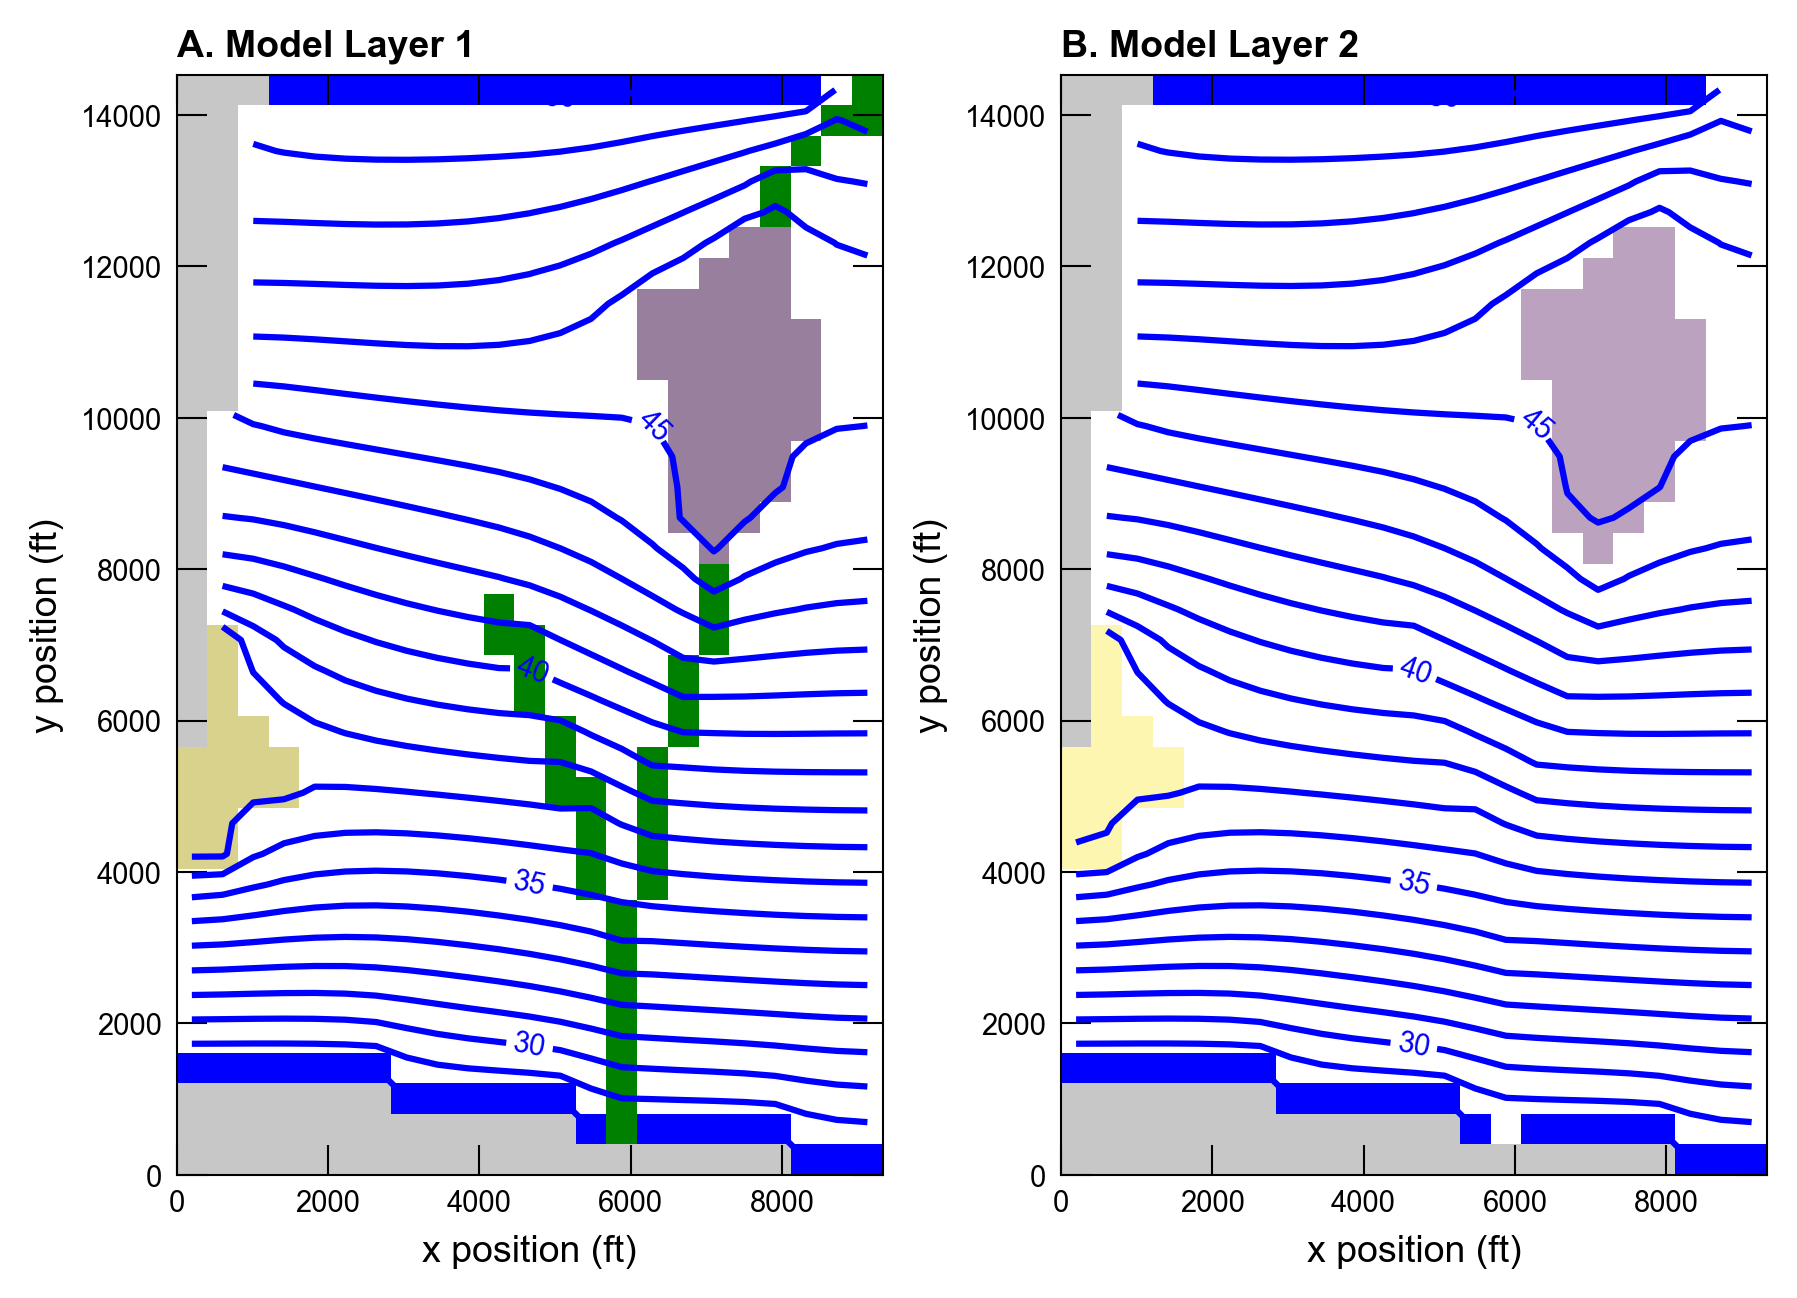

Plotting model results...


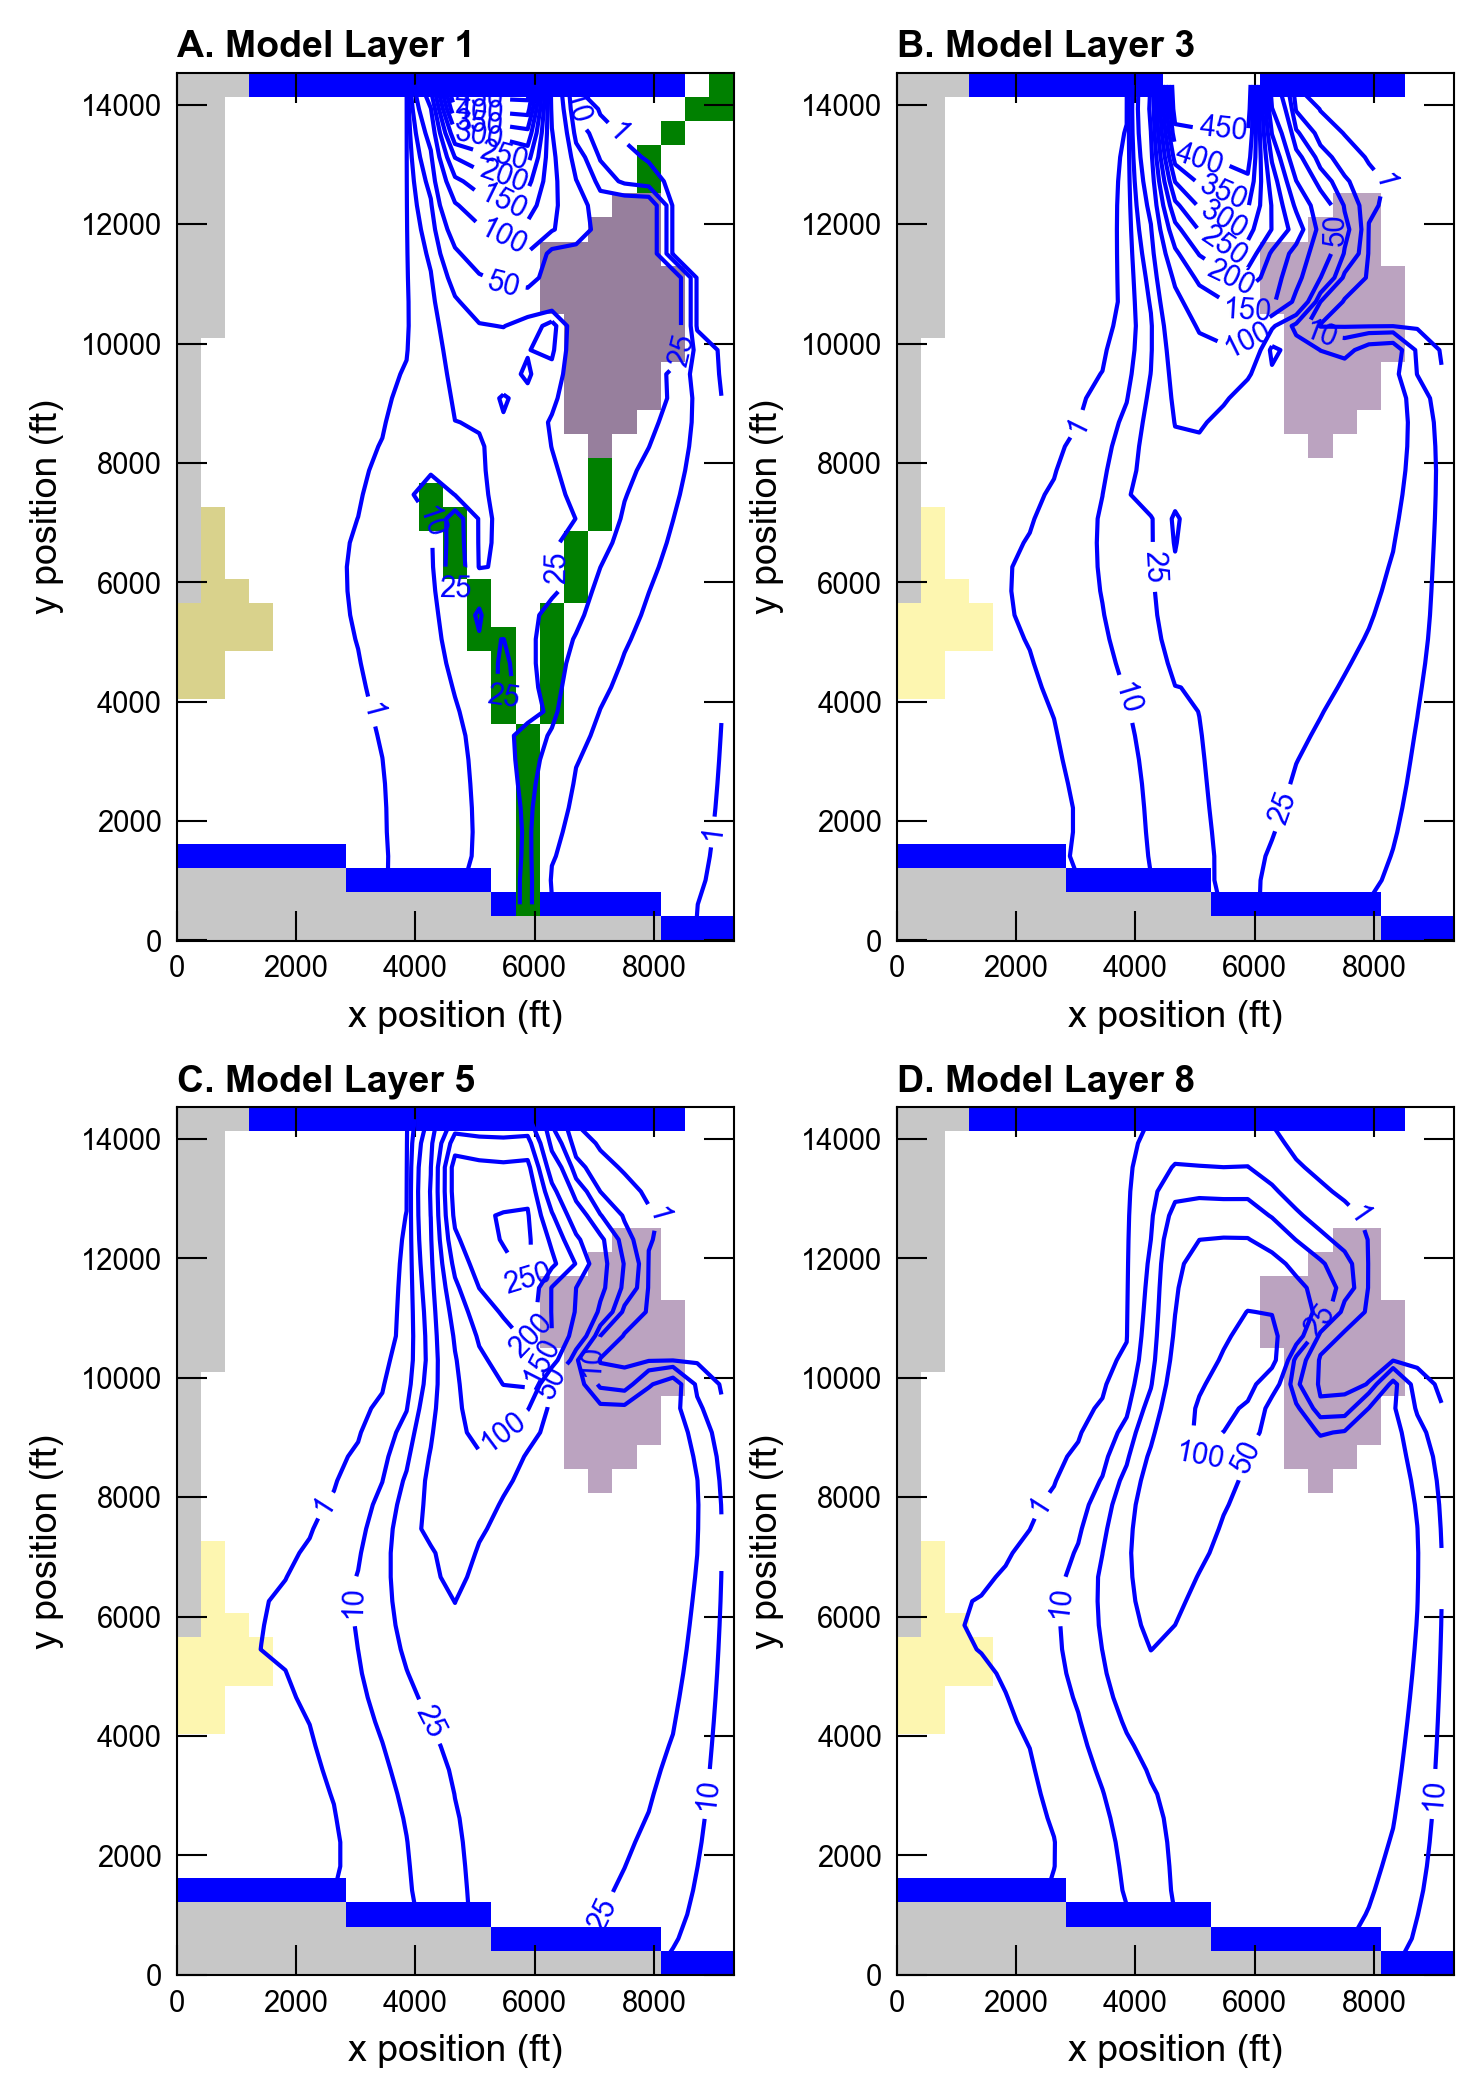

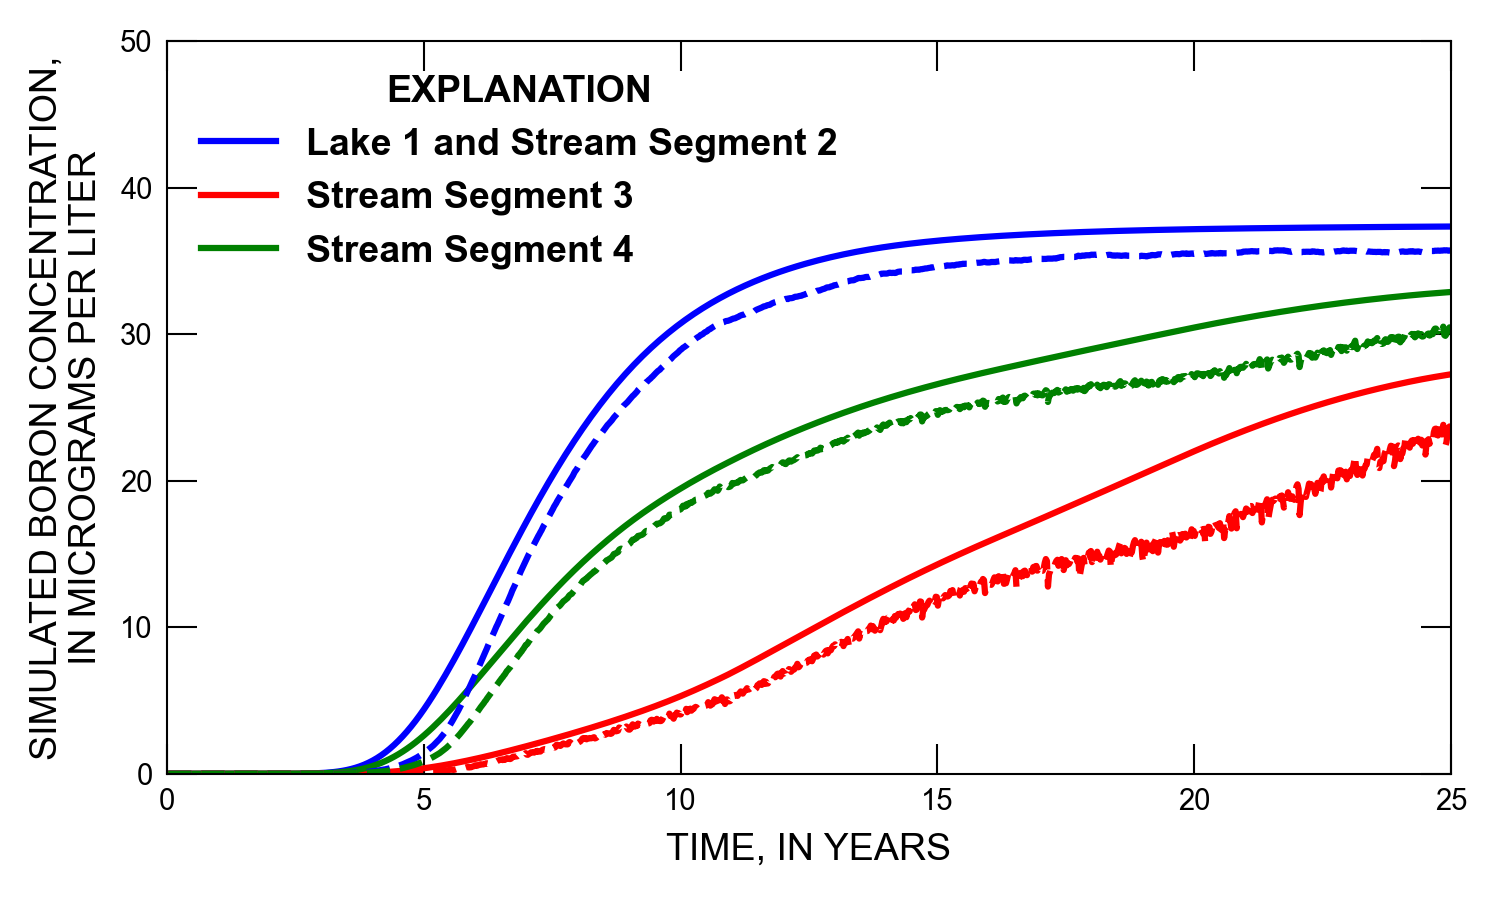

In [5]:
def scenario(silent=True):
    sims = build_models(sim_name)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)
    if plot:
        plot_results(sims)


scenario()